# Item Based Recommender System  
-------------
_Authors: Carleton Smith_

## Project Guide  
-------------
 - [Project Overview](#project-overview)
 - [Reading in the Data](#read-in)
     - [EDA](#eda)  
       
       
 - [Functioning of Recommender Systems](#simple)
     - [Predicting Unknown Scores](#pred)  
     
     
 - [Return to the Data](#ret)
 - [Utilization Complexities](#util)
 - [SVD](#svd)
 - [Surprise - Python package](#surprise)  
 
 <a id = "project-overview"></a>
 ## Project Overview  
 --------  
 #### EXPECTED TIME: 2.5 HRS  
 
 This project generally proceeds in 4 parts:  
 
 - General Familiarization with data.
 - Mathematical foundations of, and simple examples of recommender systems.
 - Execution of methods on data.
 - Short introduction to `Surprise` package.   
 
The methods used below should all be familiar from the lectures found in week 9. Some concepts will be reviewed before applying, but in some cases, SVD notably, particular will not be reviewed, only execution will be demonstrated.

The general goal is: given a collection of users, items and user reviews of items, predict what score a user would choose for an item they have yet to review.  

We will be working with a synthetic review dataset, modeled on reviews from Amazon. For our examples we will work with a small amount of made-up data, to demonstrate  techniques.  

Activities include:  
- Manipulating DataFrames
- Visualizing data  
- Calculating distance in multiple ways  
- Calculating and interpreting similarity scores  
- Using `numpy`'s SVD function  
- Learning about the `Surprise` package  


**Motivation:** Recommender systems provide non-parametric comparisons between items. They are foundational in how individuals are served and thus navigate the web.  

**Objectives:**  

- Understand mathematical foundations of recommender systems.
- Translation of mathematical algorithm into code.

#### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

### Reading in the data
This assignments we will be using  some synthetic data, modeled on Amazon product reviews. A description of the review data available and instructions to pull down actual Amazon review data [can be found here](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).  

Before turning to our synthetic data, see below the sample of actual Data from Amazon.

In [4]:
sample_data_path = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/sample_us.tsv"

rev_df = pd.read_table(sample_data_path)

rev_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18778586,RDIJS7QYB6XNR,B00EDBY7X8,122952789,Monopoly Junior Board Game,Toys,5,0,0,N,Y,Five Stars,Excellent!!!,2015-08-31
1,US,24769659,R36ED1U38IELG8,B00D7JFOPC,952062646,56 Pieces of Wooden Train Track Compatible wit...,Toys,5,0,0,N,Y,Good quality track at excellent price,Great quality wooden track (better than some o...,2015-08-31
2,US,44331596,R1UE3RPRGCOLD,B002LHA74O,818126353,Super Jumbo Playing Cards by S&S Worldwide,Toys,2,1,1,N,Y,Two Stars,Cards are not as big as pictured.,2015-08-31
3,US,23310293,R298788GS6I901,B00ARPLCGY,261944918,Barbie Doll and Fashions Barbie Gift Set,Toys,5,0,0,N,Y,my daughter loved it and i liked the price and...,my daughter loved it and i liked the price and...,2015-08-31
4,US,38745832,RNX4EXOBBPN5,B00UZOPOFW,717410439,Emazing Lights eLite Flow Glow Sticks - Spinni...,Toys,1,1,1,N,Y,DONT BUY THESE!,Do not buy these! They break very fast I spun ...,2015-08-31


#### Looking at our raw data

While NLP might offer insight into the structure of reviews, for the purpose of this assignment, we are only interested in the customers, the product, and the star rating

In [5]:
rev_df = rev_df[['customer_id','product_id', 'star_rating']]
rev_df.rename(columns= {'star_rating':'score'}, inplace=True)
rev_df.head()

,customer_id,product_id,score
0,18778586,B00EDBY7X8,5
1,24769659,B00D7JFOPC,5
2,44331596,B002LHA74O,2
3,23310293,B00ARPLCGY,5
4,38745832,B00UZOPOFW,1


#### Question 1

In [6]:
### GRADED
### in the call to `.rename()` above, a dictionary was passed in to the `columns` parameter
### Which other object, when passed to 'columns', whould have yeilded the same result
### 'a') "reviewerID, productID, score"
### 'b') ['asin':'productID','overall':'score']
### 'c') ['customer_id', 'product_id', 'score']
### 'd') None of the above
### assign character - as string - associated with your choice to ans1
### YOUR ANSWER BELOW

ans1 = 'c'

In [7]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


While not strictly necessary, let's modify the values in product_id and customer_id to make them a little easier to read.  

Below, building a dictionary for products.  
Let the keys be all the unique values of productID, let the values be "P" followed by a number, 1-n, such that each product id is mapped to a unique string of the format ("P####"). Do the same for Reviewers, but use a "R" prefix.

In [8]:
pID_dict = {pID:'P'+ str(idx) for idx, pID in enumerate(rev_df['product_id'].unique()) }
rID_dict = {rID:'R'+ str(idx) for idx, rID in enumerate(rev_df['customer_id'].unique()) }

### Checking the values in the dictionaries below:
for k in list(pID_dict.keys())[:5]:
    print(k, ":",pID_dict[k])
print("length: ",len(pID_dict))

B00EDBY7X8 : P0
B00D7JFOPC : P1
B002LHA74O : P2
B00ARPLCGY : P3
B00UZOPOFW : P4
length:  49


In [9]:
### Renaming of product and reviewer IDs 

rev_df.loc[:, 'product_id'] = rev_df.loc[:,'product_id'].map(pID_dict)
rev_df.loc[:, 'customer_id'] = rev_df.loc[:,'customer_id'].map(rID_dict)

rev_df.head()

,customer_id,product_id,score
0,R0,P0,5
1,R1,P1,5
2,R2,P2,2
3,R3,P3,5
4,R4,P4,1


<a id = "eda"></a>
### EDA
Having gone through the proess of cleaning the data, we will load in our more extensive synthetic data-set and perform some light EDA to look at the distributions of the data.

In [10]:
synth_data_path = "../resource/asnlib/publicdata/synthetic_reviews.csv"

rev_df = pd.read_csv(synth_data_path)
rev_df.head()

,reviewerID,productID,score
0,R0,P6181,5
1,R0,P2276,2
2,R0,P1382,5
3,R0,P4797,5
4,R0,P281,1


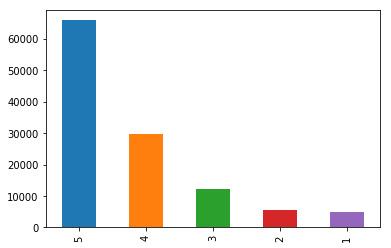

In [11]:
rev_df['score'].value_counts().plot(kind = 'bar');

In [12]:
rev_df['score'].value_counts()

5    65826
4    29717
3    12352
2     5604
1     4981
Name: score, dtype: int64

Interesting preponderance of 5's.  

In [13]:
print("Reviews per product, top and bottom reviewed\n")
print(rev_df['productID'].value_counts()[:15])
print(rev_df['productID'].value_counts()[-5:])

Reviews per product, top and bottom reviewed

P4407    302
P6092    290
P677     264
P4492    250
P1099    210
P2535    191
P1959    190
P4597    189
P3829    188
P2214    184
P3579    183
P540     180
P2245    178
P3437    176
P3342    172
Name: productID, dtype: int64
P2209    1
P3174    1
P5171    1
P2343    1
P4911    1
Name: productID, dtype: int64


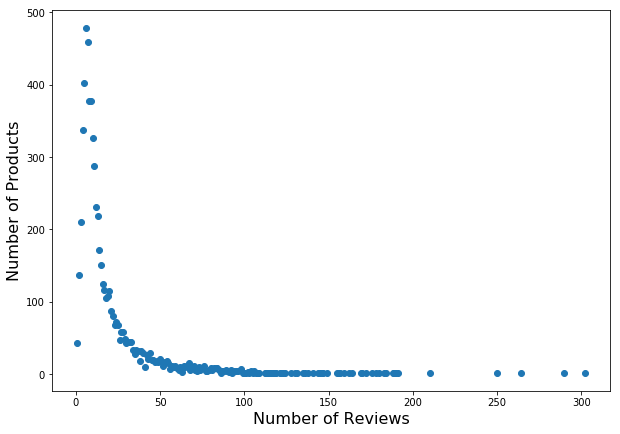

In [14]:
product_w_n_reviews = rev_df['productID'].value_counts().value_counts()
plt.figure(figsize = (10,7))
plt.scatter(product_w_n_reviews.index, product_w_n_reviews)
plt.xlabel("Number of Reviews", fontsize = 16)
plt.ylabel("Number of Products", fontsize = 16);

Of note, the above looks log-normal, however, in reality, the distribution will look like the distribution called "the hollow" curve, which is frequently found in nature in relative species abundance. the log-normal appearance is an artifact of the data synthesis.

In [15]:
print("Reviews per reviewer, top and bottom reviewers\n")
print(rev_df['reviewerID'].value_counts()[:15])
print(rev_df['reviewerID'].value_counts()[-5:])

Reviews per reviewer, top and bottom reviewers

R8577    578
R8247    578
R2603    375
R4759    375
R3429    375
R1396    301
R9317    301
R3559    261
R830     256
R8531    256
R8114    246
R6339    246
R6324    246
R4022    246
R4749    200
Name: reviewerID, dtype: int64
R4204    5
R5361    5
R6534    5
R5688    5
R9062    5
Name: reviewerID, dtype: int64


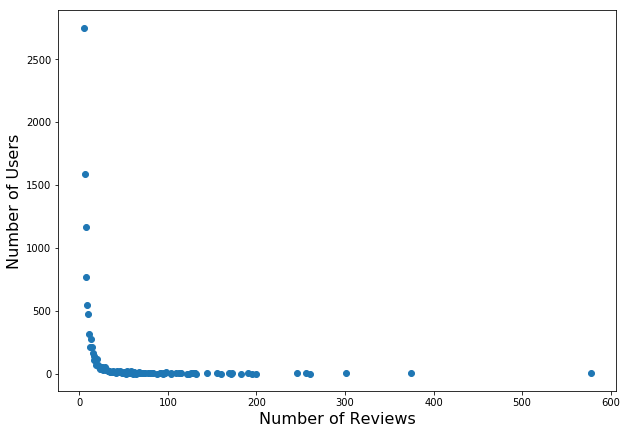

In [16]:
product_w_n_reviews = rev_df['reviewerID'].value_counts().value_counts()
plt.figure(figsize = (10,7))
plt.scatter(product_w_n_reviews.index, product_w_n_reviews)
plt.xlabel("Number of Reviews", fontsize = 16)
plt.ylabel("Number of Users", fontsize = 16);

Most products are only reviewed a few times; most users only submit a few reviews. Very few products/users have/submit many many reviews. The above is more the look of a "hollow curve".

<a id = "simple"></a>
### Functioning of Recommender Systems

Before tackling our extensive synthetic data, we will use a simpler dataset to demonstrate the functioning of recommender systems.  

Below we have a set of rankings of six musicians made by six individuals.  

In [17]:
ex = pd.read_csv("../resource/asnlib/publicdata/example.csv", index_col = 0)
ex

,Mozart,Bach,Chopin,Brahms,Wagner,Liszt
Abel,0,1,2,2,1,3
Baker,5,0,3,2,3,3
Charlie,5,4,0,5,3,2
David,5,5,5,0,2,1
Erik,3,3,4,3,0,2
Frank,2,2,1,1,3,0


Every column and every row contains 1 value of "0", denoting an absence of ranking - NOT an extremely poor ranking.  

To determine which products to recommend, the similarity of products will be used. We will use three different ways to calculate similarity: Euclidean distance, correlation coefficient (Pearson's), and a cosine similarity score. In order to compare these scores we will normalize each to range between 0 and 1.  

To help review each, we will use a subset of our example DataFrame:

In [18]:
ex_hand = ex.iloc[:3,-3:]
ex_hand

,Brahms,Wagner,Liszt
Abel,2,1,3
Baker,2,3,3
Charlie,5,3,2


Euclidean distance for points i, and j  is $\sqrt{(a_j-a_i)^2+(b_j-b_i)^2+...+(n_j-n_i)^2}$  

#### Question 2

In [19]:
### GRADED
### calculate the Euclidean distance between Brahms and Wagner in the `ex_hand` DataFrame
### Assign float answer to ans1.
### response graded to 3 decimal places 
### Feel free to refer to KNN assignment
### YOUR ANSWER BELOW

ans1 = np.sqrt(np.sum((ex_hand.Brahms - ex_hand.Wagner)**2))

In [20]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


To normalize this to between 0 and 1, the transformation from "distance" to "similarity" is $\frac1{1+dist}$. e.g. distance of 0 = similarity of 1, and $lim_{dist\rightarrow\infty}$ similarity approaches 0.  

#### Question 3

In [21]:
### GRADED
### Code a function called "e_sim"
### ACCEPT two pandas series as inputs
### RETURN the euclidean similarity score

### Hint: remember `np.linalg.norm()`
### YOUR ANSWER BELOW

def e_sim(ser1, ser2):
    """
    Given two Pandas series, compute the euclidean similarity score;
        1 / 1+euclidean distance
        
    Positional Arguments --
        ser1: a Pandas Series of length n
        ser2: a Pandas Series of length n
    
    Example --
        ser1 = ex_hand.iloc[:,0]
        ser2 = ex_hand.iloc[:,1]
        print(e_sim(ser1, ser2)) #--> 0.28989794855663564
    """
    
    return 1/(1+np.linalg.norm(ser1 - ser2))

In [22]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Pearson's Correlation Coefficient
The correlation coefficient - $\rho$ - that same one you learned about in intro to statistics -  ranges from -1 to 1, thus in order to normalize into a difference score between 0 and 1, we need to reduce that range by half -- divide by two -- and increase the minimum score to 0 -- add .5:  

$$\frac12 + \frac{\rho_{xy}}2$$  

In [23]:
### Defining function for pearson's Correlation Coefficient
def p_sim(ser1, ser2):
    
    def normalize(raw):
        return .5 + (raw/2)
    
    corr = np.corrcoef(ser1, ser2)[0][1] ### returns 2x2 array with correlation to self(1) on diagonal
    
    return normalize(corr)

#### Cosine Similarity

Cosine similarity calculates the cosine of the angle between two vectors, once again, normalizing between 0 and 1.  

#### Question 4

In [24]:
### GRADED
### True or False:
### Like the correlation coefficient similarity score, cosine similarity score will be unaffected by magnitudes
### e.g. an excited user who gives mostly 5's will be considered similar to a user who gives mostly 2's

### Assign boolean response to ans1
### YOUR ANSWER BELOW

ans1 = True

In [25]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


The equation for the cosine similarity score is the dot product of two vectors over the product of the norm of the two vectors: $$cos\theta = \frac{S1\cdot S2}{||S1||*||S2||}$$

In [26]:
### Define function for cosine similarity

def c_sim(ser1, ser2):
    def normalize(raw):
        return .5 + (raw/2)
    
    cosT = np.dot(ser1, ser2) / (np.linalg.norm(ser1)* np.linalg.norm(ser2))
    
    return normalize( cosT)

At this point we have defined three functions for calculating similarity between two vectors.  

- c_sim: for cosine similarity
- p_sim: for pearson coorelation coefficient similarity
- e_sim: for euclidean similarity  

Let's now calculate each of the three similarity scores for each pair of musicians in our `ex` DataFrame.  

The function we will build must take into account that not all users have rated all musicians.

In [27]:
ex

,Mozart,Bach,Chopin,Brahms,Wagner,Liszt
Abel,0,1,2,2,1,3
Baker,5,0,3,2,3,3
Charlie,5,4,0,5,3,2
David,5,5,5,0,2,1
Erik,3,3,4,3,0,2
Frank,2,2,1,1,3,0


So, for example, when "Mozart", and "Bach" are compared, the observations from both "Abel" and "Baker" must be disregarded.  
Although our similarity functions will happily ingest the value of "0", The functions will take 0 to mean "less than 1" , *not* the "no information" which it actually represents.  

#### Question 5

In [28]:
### GRADED
### Code a function called "drop_val"
### ACCEPT two inputs; A pandas DataFrame and a value, 'to_drop'
### Drop all of the *rows* that contain the value 'to_drop' in any column
### RETURN DataFrame with rows dropped

### e.g. As demonstrated in the doc-string;
### Passing a DataFrame based on 'ex' containing all rows but only the "Mozart" and "Bach" columns
### and a 'to_drop' of 5 should return the "Abel", "Erik", and "Frank" rows with all the original columns

### YOUR ANSWER BELOW

def drop_val (df, to_drop):
    
    """
    Drop rows from the DataFrame containing the specified values
    
    Positional Arguments --
        df: a Pandas DataFrame
        to_drop: a value found in some rows of df
    
    Example --
        
        df = ex.loc[:,"Mozart":"Bach]
        to_drop = 5
        print(drop_val(df,to_drop)) # -->          Mozart  Bach
                                            Abel        0     1
                                            Erik        3     3
                                            Frank       2     2
        
        
    """
    for col in df.columns:
        df = df[df[col] != to_drop]
    return df

In [29]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


The below cell defines a function "drop_rows_with_zeros" that ingests a DataFrame of two columns and returns a DataFrame where all the rows that contain a value of 0 have been removed

In [30]:
### Defining drop_rows_with_zeros

def drop_rows_with_zeros(df):
    keep = np.intersect1d( np.nonzero(df.iloc[:,0]), np.nonzero(df.iloc[:,1]))
    
    return df.iloc[keep,:]


### Comparison of Similarity Scores

Below, the similarity scores for each each combination of musicians will be compared for each similarity score.  

Find all the pairs of musicians:

In [31]:
import itertools
for c in itertools.combinations(ex.columns,2):
    print(c)

('Mozart', 'Bach')
('Mozart', 'Chopin')
('Mozart', 'Brahms')
('Mozart', 'Wagner')
('Mozart', 'Liszt')
('Bach', 'Chopin')
('Bach', 'Brahms')
('Bach', 'Wagner')
('Bach', 'Liszt')
('Chopin', 'Brahms')
('Chopin', 'Wagner')
('Chopin', 'Liszt')
('Brahms', 'Wagner')
('Brahms', 'Liszt')
('Wagner', 'Liszt')


Check to see how the tuples can be used to subset the DataFrame.

In [32]:
ex[list(('Mozart', 'Bach'))]

,Mozart,Bach
Abel,0,1
Baker,5,0
Charlie,5,4
David,5,5
Erik,3,3
Frank,2,2


Building a dictionary with a key of the musicians being compared, and Value of another dictionary.  
In that second dictionary, keys of "Euclid", "Pearson", and "Cosine" with values of similarity score calculated with relevant method

In [33]:
sim_scores = dict()

for c in itertools.combinations(ex.columns, 2):
    df = drop_rows_with_zeros(ex[list(c)])
    ser1 = df.iloc[:,0]
    ser2 = df.iloc[:,1]
    scores = {"Euclid":e_sim(ser1, ser2), "Pearson":p_sim(ser1,ser2), "Cosine":c_sim(ser1,ser2)}
    key =", ".join(c)
    sim_scores[key] = scores
    
sims = pd.DataFrame.from_dict(sim_scores,orient = "index")
sims

,Euclid,Pearson,Cosine
"Bach, Brahms",0.366025,0.915761,0.982382
"Bach, Chopin",0.366025,0.927618,0.983997
"Bach, Liszt",0.166667,0.021909,0.863054
"Bach, Wagner",0.231662,0.690693,0.945785
"Brahms, Liszt",0.224009,0.091752,0.923659
"Brahms, Wagner",0.240253,0.596225,0.921332
"Chopin, Brahms",0.414214,0.974342,0.994881
"Chopin, Liszt",0.179129,0.028060,0.897253
"Chopin, Wagner",0.210897,0.423553,0.900668
"Mozart, Bach",0.500000,0.973365,0.997200


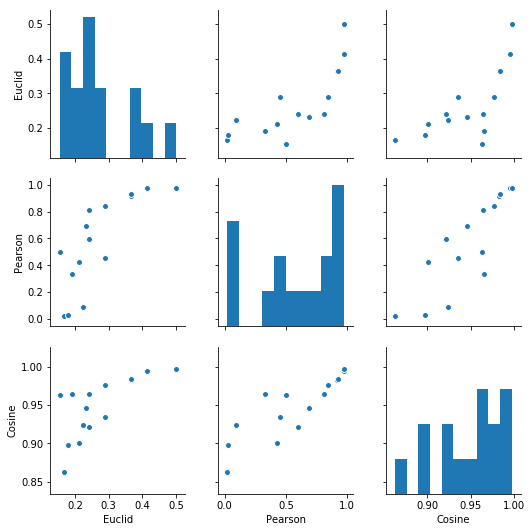

In [34]:
### Note: X and y scales are not consistent in this visualization
sns.pairplot(sims );

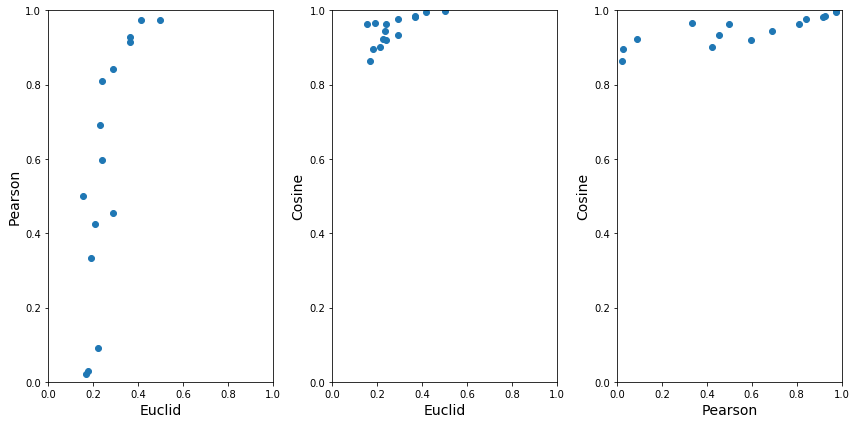

In [35]:
### Visualization with consistent scales using `matplotlib`
plt.figure(figsize = (12,6))
for i, cols in enumerate([('Euclid','Pearson'), ("Euclid","Cosine"),("Pearson","Cosine")]):
    plt.subplot(1,3,i+1)
    
    plt.scatter(sims[cols[0]], sims[cols[1]])
    
    plt.xlabel(cols[0], fontsize = 14); plt.ylabel(cols[1], fontsize = 14)
    plt.xlim(0,1); plt.ylim(0,1)
    
plt.tight_layout()

<a id = "sim-note"></a>
### Differences in Similarity Scores

One final technique - not implemented above - is to normalize scores before calculating a euclidean similarity score.  For example, a the mean score might be subtracted to center all scores around 0. This would help to spread the Euclidean similarity scores out over the entire length of 0-1 instead of clustering them below ~.6  


As should be evidenced by the above graphics, it is possible to see a range of similarity scores given different techniques. These similarity scores will majorly impact how a recommender system performs. Please refer to the lectures for the particular impacts and strengths of the different similarity calculations.

In [36]:
ex

,Mozart,Bach,Chopin,Brahms,Wagner,Liszt
Abel,0,1,2,2,1,3
Baker,5,0,3,2,3,3
Charlie,5,4,0,5,3,2
David,5,5,5,0,2,1
Erik,3,3,4,3,0,2
Frank,2,2,1,1,3,0


<a id = 'pred'></a>
### Predicting Unknown Scores

#### Question 6
In predicting Abel's score for Mozart:  

Mozart has a similarity score in relation to Bach.  
Mozart has a similarity score in relation to Chopin.  
Mozart has a similarity score in relation to Brahms.  
etc. etc.  

Abel has scored Bach, Chopin, Brahms, etc.  

So Abel's predicted score for Mozart will **sum** Abel's score of every other musician times that musician's similarity score with respect to Mozart and **divide by** the sum of similarity scores.  

e.g.

We can predict Abel's score for Mozart by:  

$$\frac{\sum_{ mus = Bach}^{Liszt}A_{mus}*simScore(\text{Mozart, mus})}{\sum_{mus = Bach}^{Liszt}simScore{\text{(Mozart, mus)}}}$$ 

In [37]:
mozSimScores = {}
for mus in ex.columns[1:]:
    no_zeros = drop_rows_with_zeros(ex[['Mozart', mus]])
    
    mozSimScores[mus] = round(p_sim(no_zeros.iloc[:,0], no_zeros.iloc[:,1]),2)

print(mozSimScores)

{'Bach': 0.97, 'Chopin': 0.84, 'Brahms': 0.81, 'Wagner': 0.33, 'Liszt': 0.5}


In [38]:
### GRADED
### Given the similarity scores calculated and stored (and rounded) in `mozSimScores`,
### use the above formula for predicting
### a score [(sum of <ranking * similarity scores>)/ sum of similarity scores]
### to predict Abel's score for Mozart.

### USE ROUNDED SCORES PRINTED / SAVED ABOVE

### Store in ans1
### YOUR ANSWER BELOW
sScores = []; abelS = []
for k in mozSimScores:
    ss = mozSimScores[k]
    sScores.append(ss)
    abelS.append(ss*ex.loc['Abel',k])
ans1 = sum(abelS)/ sum(sScores)

In [39]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


Even though many other users rate Mozart very highly, Abel appears to be a bit more negative in his reviews. Thus, his predicted score for Mozart is also fairly low. 

In [40]:
### Creating a function to create predictions in the manner described above.
### Note: "user" is a row, and "item" is a column in the df.
### simFunc defaults to p_sim

def scorePred(df, user, item, simFunc = p_sim, rev_items = None):
    """
    Positional Arguments --
        df: Pandas DataFrame
        user: Row-index in df
        item: Column-index in df
        simFunc: a similarity function (e_sim, p_sim, or c_sim)
        rev_items: For larger dfs, specifies all items reviewed by "user"
    """
    # Check to see if user has already scored item
    if df.loc[user,item] > 0:
        return "Already rated a "+str(df.loc[user,item])
    
    # rev_items used for larger dataframes,
    # when you have all the items a particular user has reviewed already
    # otherwise, if "None" (if statement below)
    # take all other items other than item to predict
    if not rev_items:
        rev_items = set(df.columns)
        rev_items.remove(item)
    
    sim_total, user_sim_total = 0,0
    
    for other_item in rev_items:
        user_score_other_item = df.loc[user, other_item] # grab user score
        
        if user_score_other_item == 0:
            print("no user score")
            continue
        
        # Use function built above to drop all other users with "other_item" score of "0"
        no_zeros = drop_rows_with_zeros(df[[item, other_item]]) 
        sh = no_zeros.shape
        
        # If no other users, move to next item
        if sh[0] == 0:
            continue
            
        #print(no_zeros.shape)
        
        # calculate similarity score using non-zero information. 
        ser1 = no_zeros.iloc[:,0]
        ser2 = no_zeros.iloc[:,1]
        # print(ser1, ser2)
        ss = simFunc(no_zeros.iloc[:,0], no_zeros.iloc[:,1])
        # print(ss, user_score_other_item)
        
        # add up sim total and weighted sim total
        sim_total += ss
        user_sim_total += user_score_other_item * ss

        
    if sim_total == 0:
        return 0
    
    else:
        return user_sim_total / sim_total

In [41]:
ex

,Mozart,Bach,Chopin,Brahms,Wagner,Liszt
Abel,0,1,2,2,1,3
Baker,5,0,3,2,3,3
Charlie,5,4,0,5,3,2
David,5,5,5,0,2,1
Erik,3,3,4,3,0,2
Frank,2,2,1,1,3,0


Use the below cells to play around with the `scorePred` function we have built out.

In [42]:
scorePred(ex, 'Baker', 'Bach')

3.2921132547922984

<a id = "ret"></a>
### Returning to the Data
Let's remind ourselves what the music rating data looks like

In [43]:
rev_df.head(10)

,reviewerID,productID,score
0,R0,P6181,5
1,R0,P2276,2
2,R0,P1382,5
3,R0,P4797,5
4,R0,P281,1
5,R0,P5556,5
6,R0,P1523,4
7,R0,P4693,4
8,R0,P5494,5
9,R0,P2245,5


The data does not conform to the n-by-p matrix that we have been using, let's take a look at how we will need to manipulate our data. To do so we will use `Pandas'` built in `pivot()` method

In [44]:
# reviewers on rows, item on cols. 
reshaped_reviews = rev_df.pivot(index = 'reviewerID', columns = 'productID')
reshaped_reviews.fillna(0, inplace = True) # turns NA into 0
reshaped_reviews.columns = reshaped_reviews.columns.droplevel() # removes artifact of pivot function


print("shape: ", reshaped_reviews.shape)
reshaped_reviews.head()

shape:  (10000, 6411)


productID,P0,P1,P10,P100,P1000,P1001,P1002,P1003,P1004,P1005,...,P990,P991,P992,P993,P994,P995,P996,P997,P998,P999
reviewerID,,,,,,,,,,,,,,,,,,,,,
R0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As should be clear from looking at even just the head of our new DataFrame, the majority of (reviewer, product) locations are empty. Thus, when trying to provide recommendations, it will not be possible to predict scores for every (reviewer, product) combination. To predict scores, a certain amount of overlap is required.  

Below predictions are created for our reviewer called "R0"

In [45]:
### First, find the products that 'R0' has reviewed.
### These are the products that will be used for creating similarity scores.

r0 = reshaped_reviews.loc["R0", :]
r0_nonzero = np.nonzero(r0) # numpy function returns all indexes that are not "0"
r0_rev_prods = list(r0.iloc[r0_nonzero].index) # collect names of reviewed products
print(len(r0_rev_prods))
r0_rev_prods[:5]

20


['P1382', 'P1523', 'P198', 'P2245', 'P2276']

In [46]:
### Creating a list of products not reviewed by R0

# return list of all prods not in the "reviewed" list
r0_not_rev = np.setdiff1d(reshaped_reviews.columns, r0_rev_prods) 

print(len(r0_not_rev))
r0_not_rev

6391


array(['P0', 'P1', 'P10', ..., 'P997', 'P998', 'P999'], dtype=object)

The below call requires too much processing for Vocareum. Output displayed below:

In [47]:
# %%time
# ### predict scores for products not yet reviewed by R0, using function built above: `scorePred`
# ### cosine similarity used because if a product all has only one value of review (e.g. all 5s)
# ### then the standard_deviation is 0 and the correlation coefficient is not calculable

# preds = {}
# for item in r0_not_rev:
#     preds[item] = scorePred(reshaped_reviews, 'R0', item, simFunc = c_sim, rev_items = r0_rev_prods)

In [48]:
# pd.Series(preds).sort_values(ascending = False).head(10)

Running the above cells took the local machine ~7.5'. results in the picture below.
![preds](./data/r0_preds.PNG)

<a id = "util"></a>
### Utilization Complexities

Certainly if there are products that a user is likely to score a "5", that product should be recommended. However, because we are dealing with very sparse data, the confidence in our predictions will vary between product.

#### Question 7

In [49]:
### GRADED
### consider 3 products: A, B, and X
### userN has ranked products A, and B, giving each a '5' and we are predicting their score for X
### user1 has ranked products A, and X, giving each a "3"
### user2 has ranked products B and X, giving each a '2'

### Assume this is all the data we have for a product.
### What will be the similarity score between prodA and prodX? assign number to ans1
### What will be the similarity score between prodB and prodX? assign number to ans2
### YOUR ANSWER BELOW

ans1 = 1
ans2 = 1

In [50]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


#### Question 8

In [51]:
### GRADED
### given your above answer, what will be the predicted score for userN's evaluation of prodX?
### assign number to ans1
### YOUR ANSWER BELOW

ans1 = 5

In [52]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


For many of these high predicted scores, some version of the above two questions will have occurred: high similarity scores due to few overlapping reviews, and high-user score for the user who is being predicted for.  

So while the "5's" might be higher than a 4.89, if that 4.89 is based on more data, it's probably a better prediction. 
<a id = "svd"></a>
### SVD

One way we will combat this sparsity of data, and increase the speed of our algorithm is by using Singular-Value Decomposition (SVD). SVD is a demensionality reduction technique which functions by "capturing" a majority of the information present in a data set in a smaller number of variables.  

SVD relies upon some straight-forward linear algebra that is worth understanding, and has already been covered in lectures. Just incase you want more resources:  

[Here is a nice introduction.](https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/)  

[Below, we will use `numpy's` implementation of SVD](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html)

The "Sigma" variable, when squared describes how much variance is described by each vector. Below a plot of % variance explained by n vectors as n -> total number of products

![svd](./data/svd.PNG)

Around 1700 of these decomposed vectors will explain around 80% of the variance in the data. Computationally, this will make the recommendation calculations much faster: less than 1/3 of the computations will yeild 80% of the value. 

In [53]:
# # Perform SVD
# u, sigma, _ = np.linalg.svd(reshaped_reviews)

# # Create function to decompose DataFrame
# def return_svd(df , u, sigma, n):
    
#     sigN = np.mat(np.eye(n) * sigma[:n]) #arrange Sig4 into a diagonal matrix
    
#     n_svd_vectors = np.dot(df.T, np.dot(u[:,:n] , sigN.I))  #create transformed items
    
#     return pd.DataFrame(n_svd_vectors).T

# # use function to create decomposed dataframe
# svd_df = return_svd(reshaped_reviews, u, sigma, 1700)
# svd_df.columns = reshaped_reviews.columns

# # Save dataframe

# svd_df.to_csv("svd_df.csv")

The above takes too long to run. Thus the results are provided from a .csv found below.

In [54]:
svd_df = pd.read_csv("../resource/asnlib/publicdata/svd_df.csv", index_col = 0)
svd_df.head()

,P0,P1,P10,P100,P1000,P1001,P1002,P1003,P1004,P1005,...,P990,P991,P992,P993,P994,P995,P996,P997,P998,P999
0,-0.00455,-0.00678,-0.00358,-0.00071,-0.01071,-0.00035,-0.00479,-0.00499,-0.01016,-0.01439,...,-0.00098,-0.00436,-0.00476,-0.00412,-0.00055,-0.00966,-0.00911,-0.04709,-0.00300,-0.00981
1,-0.00007,0.00147,0.00042,0.00011,-0.00098,0.00017,0.00300,0.00197,0.00005,0.00162,...,-0.00055,-0.00194,0.00144,-0.00253,-0.00072,0.03690,-0.02764,-0.03646,0.00020,-0.00014
2,0.00026,-0.00453,-0.00043,-0.00052,0.00120,-0.00018,0.00090,-0.00294,-0.00173,-0.00205,...,-0.00027,-0.00055,0.00135,-0.00186,0.00026,0.02412,0.02413,0.03749,-0.00210,-0.00532
3,-0.00427,-0.00329,-0.00169,0.00027,-0.00657,0.00021,-0.00054,-0.00302,-0.00879,-0.00787,...,-0.00040,-0.00358,-0.00132,-0.00214,-0.00035,0.01791,0.01203,-0.00267,-0.00246,-0.01800
4,0.00033,0.00946,0.00124,0.00048,0.01003,0.00043,0.00988,0.00543,0.00511,0.00913,...,0.00037,-0.00037,0.00358,0.00107,0.00025,-0.01531,-0.00231,0.03653,-0.00069,-0.00651


As the shape of the `svd_df` indicates, these svd-vectors correspond to items. The calculation for recommendation will be the same, but just using these new values.  

For example, to predict the score that reviewer "R0" would give to 'P1' (Remember "R0" already reviewed "P0") involves:  
1. Find the products that R0 scored.
2. Find the similarity between those scored products and "P1"
3. Multiply those similarity scores by the scores from R0
4. Divide by sum of similarity scores.  

The downside from SVD is that the SVD must be performed before the calculations, and as was seen above, those SVD calculations take some time. Potentially, SVD would need to be performed each time a new review is added.

Finally it will be possible to create a prediction and similarities for every pair of items, which will increase computation on its own, but will hopefully give more meaningful recommendations.

In [55]:
### Creating a function to create predictions using the SVD_df
### Note: "user" is a row, and "item" is a column in the df, and a column in svd_df.
### simFunc defaults to p_sim

def scorePredSVD(df, user, item, svd_df, simFunc = p_sim, rev_items = None):
    
    # Check to see if user has already scored item
    if df.loc[user,item] > 0:
        return "Already rated a "+str(df.loc[user,item])
    
    # Code below should be familiar from "scorePred" defined above
    if not rev_items:
        rev_items = set(df.columns)
        rev_items.remove(item)
    
    sim_total, user_sim_total = 0,0
    
    for other_item in rev_items:
        user_score_other_item = df.loc[user, other_item]
        
        if user_score_other_item == 0:
            print("no user score")
            continue
            
        ser1 = svd_df.loc[:,item]
        ser2 = svd_df.loc[:,other_item]
        # print(ser1, ser2)
        ss = simFunc(ser1, ser2)
        # print(ss, user_score_other_item)
        sim_total += ss
        user_sim_total += user_score_other_item * ss

        
    if sim_total == 0:
        return 0
    
    else:
        return user_sim_total / sim_total

In [56]:
%%time
### predict scores for products not yet reviewed by R0, using function built above: scorePred
### cosine similarity used because if a product all has only one value of review (e.g. all 5s)
### then the standard_deviation is 0 and the correlation coefficient is not calculable

SVDpreds = {}
for item in r0_not_rev:
    SVDpreds[item] = scorePredSVD(reshaped_reviews, 'R0', item, svd_df, simFunc = c_sim, rev_items = r0_rev_prods)

CPU times: user 18.3 s, sys: 80 ms, total: 18.4 s
Wall time: 18.3 s


In [57]:
pd.Series(SVDpreds).sort_values(ascending = False).head()

P228     4.123518
P2145    4.122626
P2042    4.122278
P4018    4.121785
P4103    4.119743
dtype: float64

#### Question 9

In [60]:
### GRADED
### SVD is a kind of:
### 'a') variance reduction
### 'b') special type of array in Python
### 'c') dimensionality reduction
### 'd') description of central tendency
### assign character associated with your choice as a string to ans1
### YOUR ANSWER BELOW

ans1 = 'c'

In [61]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


<a id = "surprise"></a>
### Surprise - Python Package
[`Surprise`](http://surpriselib.com) is a Python package which implements a number of tools for building and testing recommender systems.[Surprise documentation](https://surprise.readthedocs.io/en/stable/)

**THE FOLLOWING CODE WILL NOT RUN ON VOCAREUM THEY ARE EXAMPLES SHOULD YOU CHOOSE TO USE `SURPRISE` IN YOUR OWN ENVIRONMENT**  


You may have to run:  

`conda install -c conda-forge scikit-surprise`  

In `Anaconda Prompt`, if it is not already installed on your computer, and possibly reinstall/update scipy, and restart Kernel:  

`conda install -c anaconda scipy`  

Below is [example code from the surprise documentation](https://surprise.readthedocs.io/en/stable/getting_started.html#)

In [62]:
# from surprise import SVD
# from surprise import Dataset
# from surprise.model_selection import cross_validate


# # Load the movielens-100k dataset (download it if needed),
# data = Dataset.load_builtin('ml-100k')

# # We'll use the famous SVD algorithm.
# algo = SVD()

# # Run 5-fold cross-validation and print results
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

[Loading in a df](https://surprise.readthedocs.io/en/stable/dataset.html?highlight=pandas#surprise.dataset.Dataset.load_from_df)

In [63]:
# import os
# from surprise import BaselineOnly
# from surprise import Reader

# # when using a df to load in data, the columns must be:
# # user, product, rating, in that order
# # a reader must be defined to describe the rating_scale
# reader = Reader(rating_scale=(0,5))

# data = Dataset.load_from_df(rev_df, reader=reader)

# # We can now use this dataset as we please, e.g. calling cross_validate
# cross_validate(BaselineOnly(), data, verbose=True)

### One final note: 

This project has based its recommendations off of camparing the similarity of *items*. It is also possible to, using the same techniques, calculate the similarity of *users*. The reason that Items was chosen here (and is usually chosen) is that there are usually fewer items which demand separate similarity calculations. This was seen in our data set as there were roughly 3.5k items and 5.5k users. When using complete data from a source, this difference will be even more significant. Of course, the more people which need to have similarity scores calculated from, the longer time to build a recommender system.